In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import itertools
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
def nmf_metrics(nmf, w, tfidf_vectorizer, plot=False, true_labels = None):
    """Prints out the accuracy and optionally makes a plot displaying the top 10 words and categories for the nmf model results"""
    # use the label fiting function from week 2 assign catagories to each document and calculate the accuracy
    if true_labels is None:
        best_label, acc = label_permute_compare(df_train.Category, get_predictions(w))
    else:
        best_label, acc = label_permute_compare(true_labels, get_predictions(w))
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    print(' HERE', tfidf_feature_names)
    if plot:
        # make a plot showing each catagory and its top words
        plot_top_words(nmf, tfidf_feature_names, 10, "NMF", best_label)
    return acc

def get_predictions(w):
    '''Once you have your w matrix this will return which column had the highest value
    ie which category the article is predicted to be'''
    predictions = np.argmax(w, axis=1)
    return predictions

def label_permute_compare(true_, predicted, n=5):
    '''Gets the combination of labels that results in the highest accuracy'''
    perms = itertools.permutations(['business', 'tech', 'politics', 'sport', 'entertainment'])
    
    acc = 0.0
    best_order = 0
    for perm in perms:
        pred = [perm[i] for i in predicted]
        pred_acc = sum([1 for x, y, in zip(list(true_), pred) if x == y]) / len(true_)
        if pred_acc > acc:
            acc = pred_acc
            best_order = perm
            
    return best_order, acc

def show_words_for_topics(topic, words,  num_words = 10):
    print("OHHHHHH", topic)
    print('MYYYYYY', words)
    '''Takes the H matrix from nmf and a matrix of the words in the text. Picks the num_words with the highest 
    score for each category and returns them'''
    return np.apply_along_axis(lambda x: words[(np.argsort(-x))[:num_words]], 1, topic)

def plot_top_words(model, feature_names, n_top_words, title, subtitles):
    '''Takes the nmf model, a list of category names and some styling information for the graph.
    It then plots a horizontal bar chart for each category. Modified from the sklearn example here
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html'''
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(subtitles[topic_idx], fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

In [3]:
# import the filter words lists
with open('train_filter_words.txt') as f:
    train_filter_words = f.read().splitlines()

with open('test_filter_words.txt') as f:
    test_filter_words = f.read().splitlines()

# import data
df_train = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')

Before we can run NMF we need to vectorise the data, one method to do that is TFID. TFID stands for Term Frequency Inverse Document Frequency. The idea is that common words that appear across many documents won't help in classification and are weighted less while words that appear in fewer documents are weighted more. The frequency a term is used in a single document is also considered and is weighted more heavily the more it is used. From sklearn the equation is “tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False ), where n is the total number of documents in the document set and df(t) is the document frequency of t.”

To do that calculation the TfidfVectorizer first has to turn the raw text data into vectors. That is done by creating a dictionary where each word is assigned a token. A matrix is then created with the rows representing documents and the columns representing tokens (or words). 

 HERE ['00' '000' '0001' ... 'zurich' 'zutons' 'zvonareva']


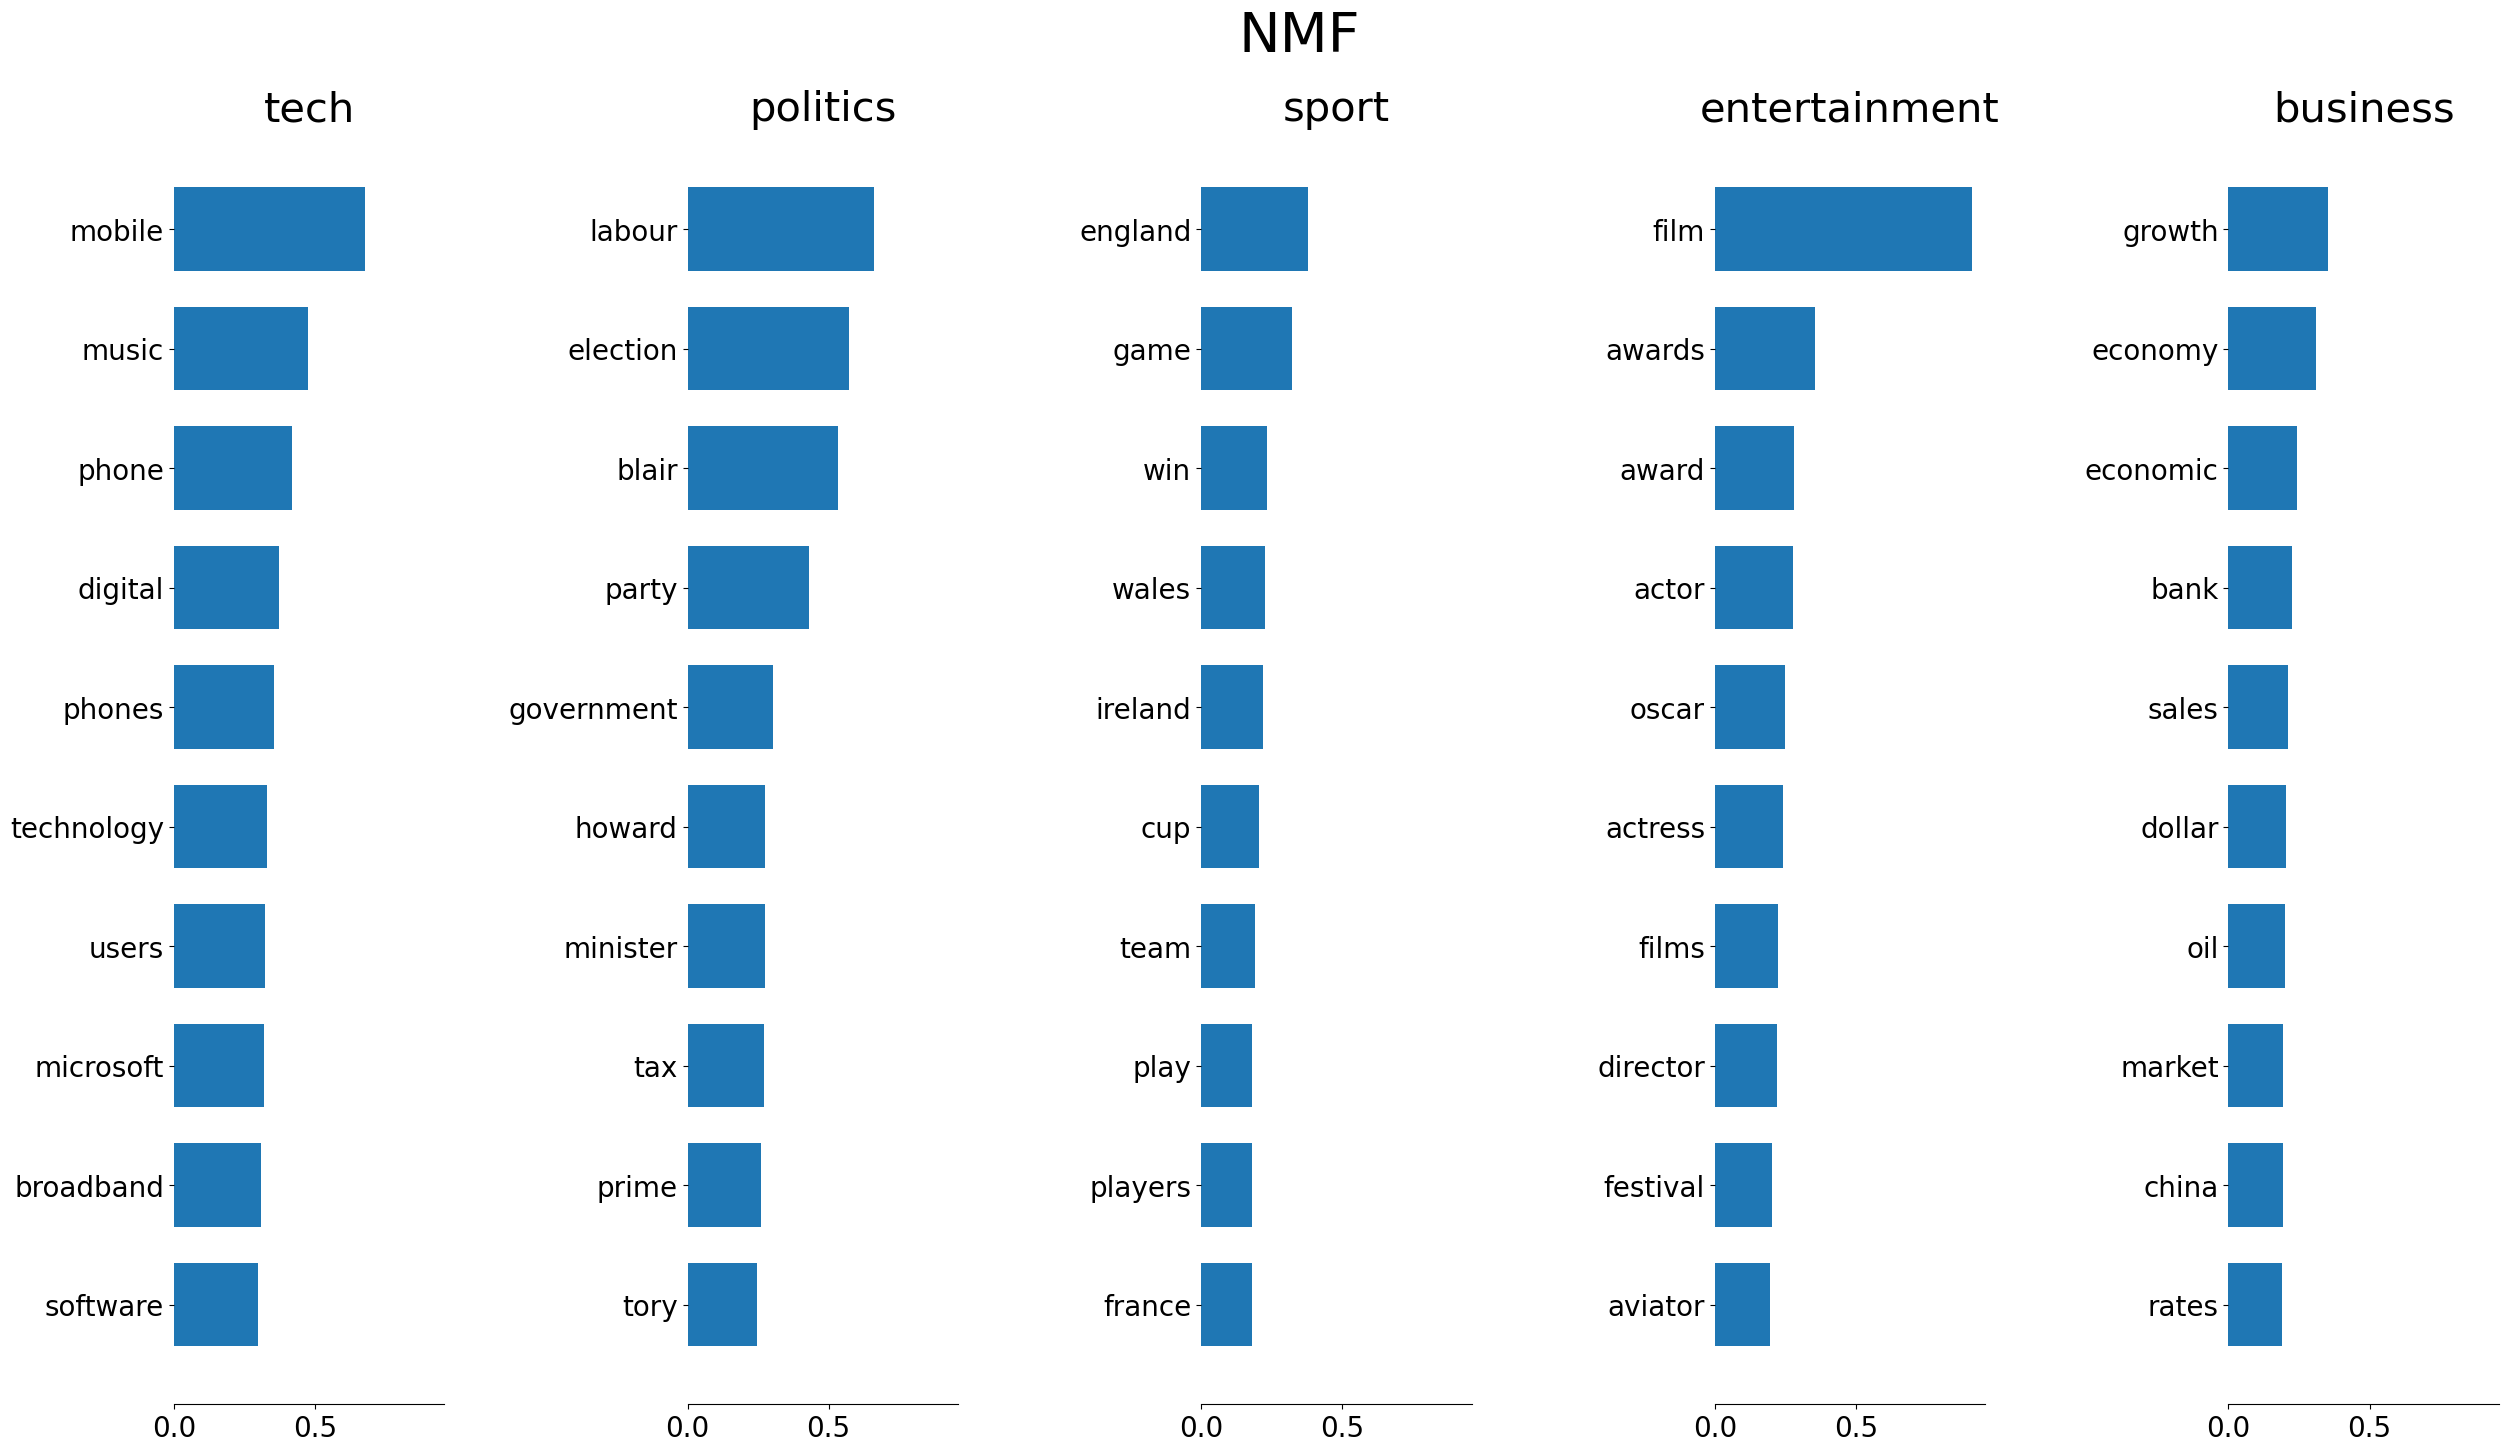

the model accuracy was : 0.9080536912751678


In [4]:
# vectorize the text using the tfidf method
def run_nmf_train(min_df = 0, max_df = 1, plot = False, use_df = False):
    if use_df == True:
        tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    else:
        tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words)
    tfidf = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())
    
    # make the nmf modle and set n_componets = to 5 because we have 5 catogries.
    nmf = NMF(n_components = 5, random_state = 0)
    # run the modle
    w = nmf.fit_transform(tfidf)
    
    acc = nmf_metrics(nmf, w, tfidf_vectorizer, plot=plot)
    return acc
    
acc = run_nmf_train(plot=True)
print('the model accuracy was : %s' % acc)

The TfidfVectorizer can create its own filter words based on the frequency the words appear in the documents. Lets see if I can do 
a better job picking filter words or if adjusting the max and min frequency requimernts produces better results.

In [5]:
max_df_list = list(range(100,0, -5))
max_df_list =[.01* val for val in max_df_list]

min_df_list = list(range(0,11, 1))
min_df_list =[.01* val for val in min_df_list]
acc_dict = {}
for max_df in max_df_list:
    for min_df in min_df_list:
        if max_df > min_df:
            acc = run_nmf_train(max_df = max_df, min_df = min_df, use_df = True)
            acc_dict[(max_df, min_df)] = acc

 HERE ['00' '000' '0001' ... 'zurich' 'zutons' 'zvonareva']
 HERE ['000' '10' '100' ... 'your' 'yukos' 'zealand']
 HERE ['000' '10' '100' ... 'young' 'your' 'zealand']
 HERE ['000' '10' '100' ... 'you' 'young' 'your']
 HERE ['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '200'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '22' '24' '25' '28' '30'
 '40' '50' 'ability' 'able' 'about' 'access' 'according' 'accused'
 'across' 'act' 'action' 'actor' 'added' 'adding' 'admitted' 'africa'
 'after' 'again' 'against' 'age' 'agency' 'ago' 'agreed' 'agreement'
 'ahead' 'alan' 'all' 'allow' 'allowed' 'almost' 'along' 'already' 'also'
 'although' 'always' 'am' 'america' 'american' 'among' 'amount' 'an'
 'analyst' 'analysts' 'and' 'andy' 'announced' 'annual' 'another' 'anti'
 'any' 'anyone' 'anything' 'appeal' 'april' 'are' 'area' 'areas' 'around'
 'as' 'asked' 'association' 'at' 'attempt' 'australian' 'available'
 'average' 'award' 'awards' 'away' 'back' 'bad' 'band' 'bank' '

/Users/benkupernk/opt/anaconda3/envs/pycharm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


 HERE ['000' '10' '12' '20' '2003' '2004' '2005' 'able' 'about' 'according'
 'action' 'added' 'after' 'again' 'against' 'ago' 'ahead' 'all' 'almost'
 'already' 'also' 'although' 'always' 'among' 'an' 'analysts' 'and'
 'another' 'any' 'are' 'around' 'as' 'at' 'away' 'back' 'based' 'bbc' 'be'
 'because' 'become' 'been' 'before' 'being' 'believe' 'best' 'better'
 'between' 'big' 'biggest' 'both' 'britain' 'british' 'business' 'but'
 'by' 'called' 'came' 'can' 'chief' 'come' 'companies' 'company' 'could'
 'country' 'current' 'currently' 'cut' 'david' 'day' 'days' 'deal'
 'december' 'decision' 'despite' 'did' 'director' 'do' 'does' 'don' 'down'
 'due' 'during' 'each' 'earlier' 'early' 'election' 'end' 'england'
 'europe' 'european' 'even' 'every' 'executive' 'expected' 'face' 'far'
 'few' 'figures' 'film' 'final' 'firm' 'firms' 'first' 'five' 'following'
 'for' 'former' 'found' 'four' 'from' 'full' 'further' 'future' 'game'
 'games' 'general' 'get' 'give' 'given' 'go' 'going' 'good' 'got'
 

/Users/benkupernk/opt/anaconda3/envs/pycharm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


 HERE ['000' '10' '12' '20' '2003' '2004' '2005' 'able' 'about' 'according'
 'action' 'added' 'after' 'again' 'against' 'all' 'already' 'also'
 'although' 'an' 'and' 'another' 'any' 'are' 'around' 'as' 'at' 'away'
 'back' 'based' 'bbc' 'be' 'because' 'become' 'been' 'before' 'being'
 'believe' 'best' 'better' 'between' 'big' 'biggest' 'both' 'britain'
 'british' 'business' 'but' 'by' 'called' 'came' 'can' 'chief' 'come'
 'companies' 'company' 'could' 'country' 'currently' 'day' 'days' 'deal'
 'decision' 'despite' 'did' 'director' 'do' 'don' 'down' 'due' 'during'
 'earlier' 'early' 'election' 'end' 'england' 'europe' 'european' 'even'
 'every' 'executive' 'expected' 'far' 'few' 'film' 'final' 'firm' 'first'
 'five' 'following' 'for' 'former' 'found' 'four' 'from' 'future' 'game'
 'games' 'general' 'get' 'give' 'given' 'go' 'going' 'good' 'got'
 'government' 'great' 'group' 'growth' 'had' 'half' 'hard' 'has' 'have'
 'he' 'held' 'help' 'her' 'high' 'him' 'his' 'hit' 'home' 'how' 'however'

The best model has an accuracy of 0.9456375838926174 with a max frequency of 0.1 and a minimum frequency of 0.01.


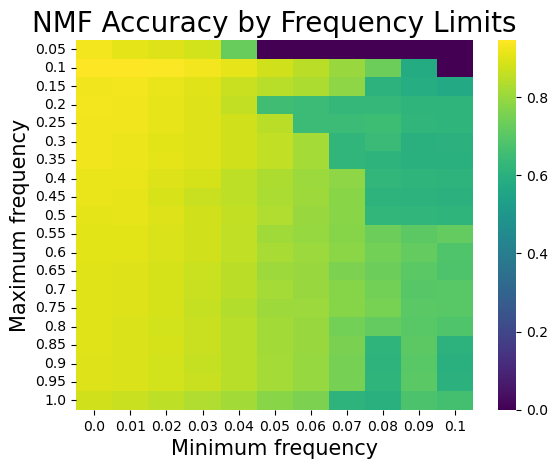

In [6]:
ser = pd.Series(list(acc_dict.values()),
                  index=pd.MultiIndex.from_tuples(acc_dict.keys()))
df_acc_results = ser.unstack().fillna(0)
df_acc_results.index = [round(idx, 2) for idx in df_acc_results.index]
ax = sns.heatmap(df_acc_results, cmap = 'viridis') 

plt.title('NMF Accuracy by Frequency Limits', fontsize = 20)
plt.xlabel('Minimum frequency', fontsize = 15)
plt.ylabel('Maximum frequency', fontsize = 15)
print('The best model has an accuracy of %s with a max frequency of %s and a minimum frequency of %s.' % 
     (max(acc_dict.values()), max(acc_dict, key=acc_dict.get)[0], max(acc_dict, key=acc_dict.get)[1]))  

Now let's run NMF with the test filter list

In [7]:
# vectorize the text using the tfidf method
tfidf_vectorizer = TfidfVectorizer(stop_words=test_filter_words)
tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# make the nmf modle and set n_componets = to 5 because we have 5 catogries.
nmf = NMF(n_components = 5, random_state = 0)
# run the modle
w = nmf.fit_transform(tfidf)

In [8]:
# get my predicted catagories
predictions = get_predictions(w)
# see the top ten words for each catagory
vocab = tfidf_vectorizer.get_feature_names_out()
print(show_words_for_topics(nmf.components_, tfidf_vectorizer.get_feature_names_out()))
print(df_train.Category.unique())

OHHHHHH [[0.00066814 0.1076287  0.         ... 0.         0.00063873 0.        ]
 [0.         0.0349529  0.         ... 0.         0.         0.        ]
 [0.00048315 0.09270811 0.         ... 0.         0.00256918 0.        ]
 [0.00190468 0.01033239 0.03337456 ... 0.         0.01879022 0.        ]
 [0.00167658 0.02816797 0.00510768 ... 0.00405899 0.00097193 0.02331455]]
MYYYYYY ['00' '000' '000m' ... 'zubair' 'zurich' 'zvyagintsev']
[['music' 'mobile' 'technology' 'digital' 'users' 'broadband' 'games'
  'apple' 'phone' 'computer']
 ['labour' 'election' 'blair' 'brown' 'party' 'howard' 'chancellor'
  'government' 'tax' 'tory']
 ['economy' 'growth' 'bank' 'prices' 'oil' 'economic' 'yukos' 'sales'
  'china' '2004']
 ['england' 'game' 'rugby' 'wales' 'win' 'match' 'play' 'players'
  'ireland' 'team']
 ['film' 'best' 'award' 'awards' 'festival' 'prize' 'oscar' 'films' 'won'
  'aviator']]
['business' 'tech' 'politics' 'sport' 'entertainment']


In [9]:
# assign each catogory to its numeric label
cat_dict = {0:'tech', 1:'politics', 2:'business', 3:'sport', 4:'entertainment'}
df_test['Category'] = [cat_dict[val] for val in predictions]
df_test
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('test_predictions.csv', index = False)

Kaggle gave me a score of 94.6%. Not too bad. Lets try with the max and min df.

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df = .1, min_df = .01)
tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# make the nmf modle and set n_componets = to 5 because we have 5 catogries.
nmf = NMF(n_components = 5, random_state = 0)
# run the modle
w = nmf.fit_transform(tfidf)

In [11]:
# get my predicted catagories
predictions = get_predictions(w)
# see the top ten words for each catagory
vocab = tfidf_vectorizer.get_feature_names_out()
print(show_words_for_topics(nmf.components_, tfidf_vectorizer.get_feature_names_out()))
print(df_train.Category.unique())

OHHHHHH [[0.00000000e+00 5.03970395e-02 2.04438244e-03 ... 9.46729329e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.01267208e-02 1.08442035e-03 ... 3.69145213e-03
  0.00000000e+00 0.00000000e+00]
 [4.38695744e-02 7.48644095e-03 2.54632246e-02 ... 1.24773683e-02
  0.00000000e+00 8.25351644e-02]
 [0.00000000e+00 3.83506573e-02 4.22857875e-03 ... 0.00000000e+00
  1.92739679e-01 0.00000000e+00]
 [3.51478083e-04 2.97423372e-02 4.77592667e-03 ... 7.51125037e-05
  0.00000000e+00 0.00000000e+00]]
MYYYYYY ['000m' '100' '100m' ... 'yourself' 'yukos' 'zealand']
[['mobile' 'music' 'digital' 'users' 'games' 'computer' 'phone' 'net'
  'video' 'software']
 ['blair' 'election' 'brown' 'howard' 'chancellor' 'prime' 'tory' 'tax'
  'tories' 'leader']
 ['club' 'wales' 'match' 'injury' 'cup' 'ireland' 'rugby' 'side' 'coach'
  'france']
 ['economy' 'bank' 'prices' 'sales' 'oil' 'economic' 'china' 'shares'
  'rise' 'yukos']
 ['award' 'awards' 'music' 'festival' 'album' 'prize' 'band' 'oscar'
  'sta

In [12]:
# assign each catogory to its numeric label
cat_dict = {0:'tech', 1:'politics', 2:'sport', 3:'business', 4:'entertainment'}
df_test['Category'] = [cat_dict[val] for val in predictions]
df_test
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('test_predictions_no_filter.csv', index = False)

Submitting the new file to Kaggle gives me a score of 92.6. A little worse than my list of filter words.

Now let's try a supervised learning approach. I'm going to use Multinomial Naive Bayes. This method works by assuming that the data distribution approximates a gaussian distribution. Since each category has a distinct set of words that seems like a successful approach. Also it works well with high dimension data.

In [13]:
big_old_list_of_stuff = []

tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words, max_df =.25, min_df = 0.05)
tdif_x = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())

train_percent_list = list(range(1, 10, 1))
train_percent_list = [round(val * .1,1) for val in train_percent_list]
for j in train_percent_list:
    X_train, X_test, y_train, y_test = train_test_split(tdif_x, df_train.Category, test_size=j, random_state=0)
    
    model1 = MultinomialNB()
    model2 = KNeighborsClassifier(n_neighbors=3)
    model3 = SVC()
    model4 = NMF(n_components = 5, random_state = 0)
    
    model1.fit(X_train, y_train) 
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)
    
    y_pred1 = model1.predict(X_train)
    y_pred2 = model2.predict(X_train)
    y_pred3 = model3.predict(X_train)
    w = model4.fit_transform(X_train)
    
    
    acc1_t = accuracy_score(y_train, y_pred1)
    acc2_t = accuracy_score(y_train, y_pred2)
    acc3_t = accuracy_score(y_train, y_pred3)
    acc4_t = nmf_metrics(model4, w, tfidf_vectorizer, plot=False, true_labels = y_train)
    
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    y_pred3 = model3.predict(X_test)
    w = model4.fit_transform(X_test)
    
    acc1_v = accuracy_score(y_test, y_pred1)
    acc2_v = accuracy_score(y_test, y_pred2)
    acc3_v = accuracy_score(y_test, y_pred3)
    acc4_v = nmf_metrics(model4, w, tfidf_vectorizer, plot=False, true_labels = y_test)
    

    big_old_list_of_stuff.append([acc1_t, acc2_t, acc3_t, acc4_t,  acc1_v, acc2_v , acc3_v, acc4_v])
big_old_df = pd.DataFrame(data = big_old_list_of_stuff, columns = ['MNB_train', 'KNN_train', 'SVC_train', 'NMF_train',
                                                                   'MNB_test', 'KNN_test', 'SVC_test', 'NMF_test'])
big_old_df 

 HERE ['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '24' '25' '30' '40' '50' 'able'
 'access' 'according' 'accused' 'act' 'action' 'actor' 'admitted' 'ago'
 'agreed' 'ahead' 'allow' 'american' 'analysts' 'announced' 'annual'
 'anti' 'april' 'asked' 'association' 'available' 'award' 'awards' 'away'
 'bank' 'based' 'bbc' 'beat' 'believe' 'believes' 'better' 'bid' 'big'
 'biggest' 'blair' 'boost' 'boss' 'break' 'britain' 'british' 'budget'
 'business' 'buy' 'called' 'came' 'campaign' 'career' 'case' 'cash'
 'centre' 'chairman' 'chance' 'chancellor' 'change' 'charles' 'chief'
 'children' 'claim' 'claimed' 'claims' 'clear' 'close' 'club' 'coach'
 'come' 'comes' 'coming' 'companies' 'company' 'compared' 'competition'
 'computer' 'consumer' 'continue' 'control' 'cost' 'costs' 'council'
 'countries' 'country' 'court' 'create' 'cup' 'current' 'currently' 'cut'
 'data' 'date' 'david' 'day' 'days' 'deal' 'december' 'decision'

,MNB_train,KNN_train,SVC_train,NMF_train,MNB_test,KNN_test,SVC_test,NMF_test
0,0.962714,0.948546,1.000000,0.848620,0.946309,0.912752,0.946309,0.838926
1,0.963926,0.939597,0.999161,0.852349,0.946309,0.922819,0.963087,0.845638
2,0.964525,0.939597,0.999041,0.860978,0.955257,0.910515,0.959732,0.841163
3,0.968680,0.938479,0.998881,0.857942,0.941275,0.889262,0.951342,0.835570
4,0.967785,0.944966,0.998658,0.857718,0.938255,0.871141,0.944966,0.852349
5,0.964765,0.932886,0.998322,0.837248,0.936242,0.878076,0.944072,0.863535
6,0.968680,0.923937,1.000000,0.823266,0.935762,0.873442,0.935762,0.862895
7,0.973154,0.922819,1.000000,0.721477,0.932047,0.865772,0.926174,0.861577
8,0.966443,0.926174,1.000000,0.865772,0.888889,0.840418,0.867263,0.857569


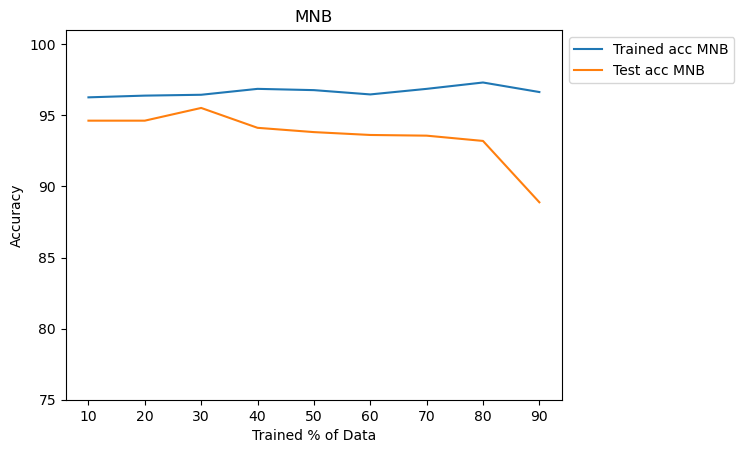

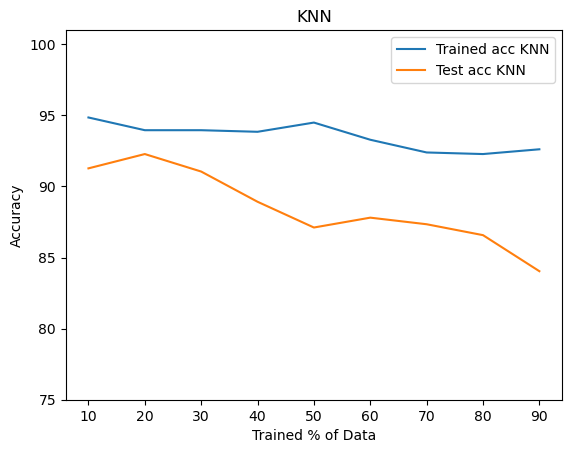

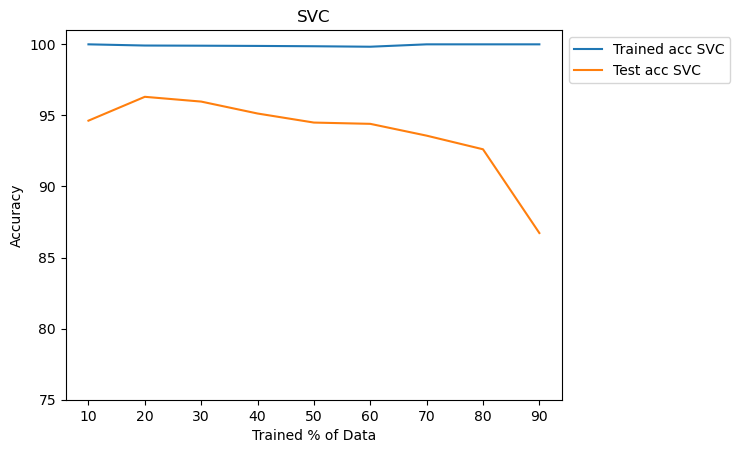

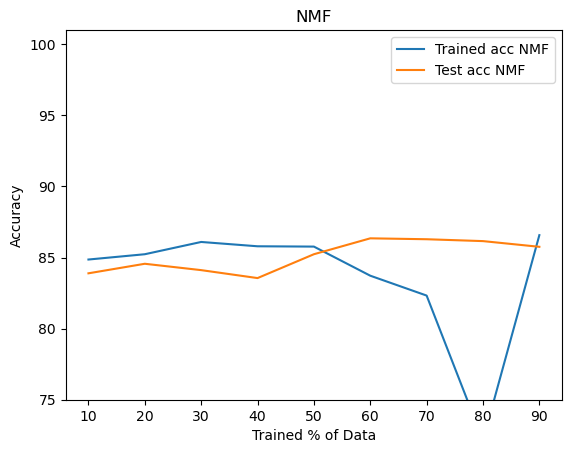

In [14]:
def model_plotter(df, model_type):
    for col in df.columns:
        if model_type in col:
            if 'train' in col:
                train_col = col
            elif 'test' in col:
                test_col = col
            else:
                print('Something bad happened and I need an adult.')
    
    plt.plot(list(range(10, 100, 10)), df[train_col]*100, label = 'Trained acc %s' % model_type)
    plt.plot(list(range(10, 100, 10)), df[test_col]*100, label = 'Test acc %s' % model_type)
    plt.xlabel("Trained % of Data")
    plt.ylabel("Accuracy")
    plt.ylim(75, 101)
    plt.title(model_type)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show() 

model_plotter(big_old_df, 'MNB')
model_plotter(big_old_df, 'KNN')
model_plotter(big_old_df, 'SVC')
model_plotter(big_old_df, 'NMF')

Based on the above graph SVC is the most accurate model and the most computationally efficient since it only needs to train on 20% of the data to achieve results better than the NMF method. It also outperforms the MNB method and not surprisingly the KNN method which does not perform well in high dimensionality. As the training data nears 90% there is a consistent drop in test accuracy in each model (with the exception of NMF) indicating overfitting.

Lets try out the SVC with the test data from Kaggle

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features = 100, stop_words=train_filter_words, max_df =.25, min_df = 0.05)

# now vectorize the test and train data
X_train_tfidf= tfidf_vectorizer.fit_transform(df_train.Text)
X_test_tfidf = tfidf_vectorizer.transform(df_test.Text)

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df_train.Category, test_size=.2, random_state=0)

# train the model
model = SVC()
model.fit(X_train, y_train)

# get the predictions for the test data
y_pred = model.predict(X_test_tfidf)

# and lets put it back into a df so we can submit it to Kaggle
df_test['Category'] = y_pred
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('svc_test_predictions.csv', index = False)

In [17]:
nmf.components_.shape

(5, 2934)

Submitting the results with a train size of 20% results in a score of 89.1%. So a little under the accuracy of the NMF method but not bad.